# Facial expression recognition 

## By Sarthak Malik

In [3]:
from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
    gpu = 'K80'
elif 'T4' in s:
    gpu = 'T4'
elif 'P100' in s:
    gpu = 'P100'
else:
    gpu='DONT PROCEED'
display(HTML(f"<h1>{gpu}</h1>"))

In [4]:
!pip install 'livelossplot'

## Importing Library

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical

from IPython.display import SVG, Image
#from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


## Getting the data

In [6]:
data_m = pd.read_csv('drive/MyDrive/Data/Facial recognition/fer2013.csv')

In [7]:
x = list(data_m["pixels"][0].split(" "))
x=np.array(x)
x

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

In [8]:
x = list(data_m["pixels"])
X = []
for i in range(len(x)):
    each_pixel = [int(num) for num in x[i].split()]
    X.append(each_pixel)
X = np.array(X)
len(x)

35887

In [9]:
data_m

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [10]:
 def load_data(sample_split=0.3, usage="training",classes=['Angry','Happy'], filepath='drive/MyDrive/Data/Facial recognition/fer2013.csv'):
      
    ###      function to prepare various dataset
      
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    x = list(df["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    y_train = df.emotion
    y_train = to_categorical(y_train)
    return X, y_train

In [11]:
path = "drive/MyDrive/Data/Facial recognition"
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
X_test, y_test = load_data(sample_split=1.0,classes=emotion,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emotion,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emotion,
usage= 'PublicTest')


In [12]:
X_test1, y_test1 = X_test, y_test
X_train1, y_train1 = X_train, y_train
X_val1,y_val1 = X_val,y_val

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)


(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)
(3589, 48, 48, 1)
(3589, 7)


In [14]:
! pip install brewer2mpl
import brewer2mpl

In [15]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]
labels = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

## Lets look into various Classes

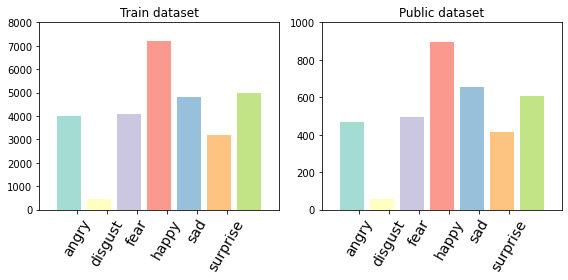

In [16]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,8), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,8), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000])

### There is class imbalance. 

## Overview of some images

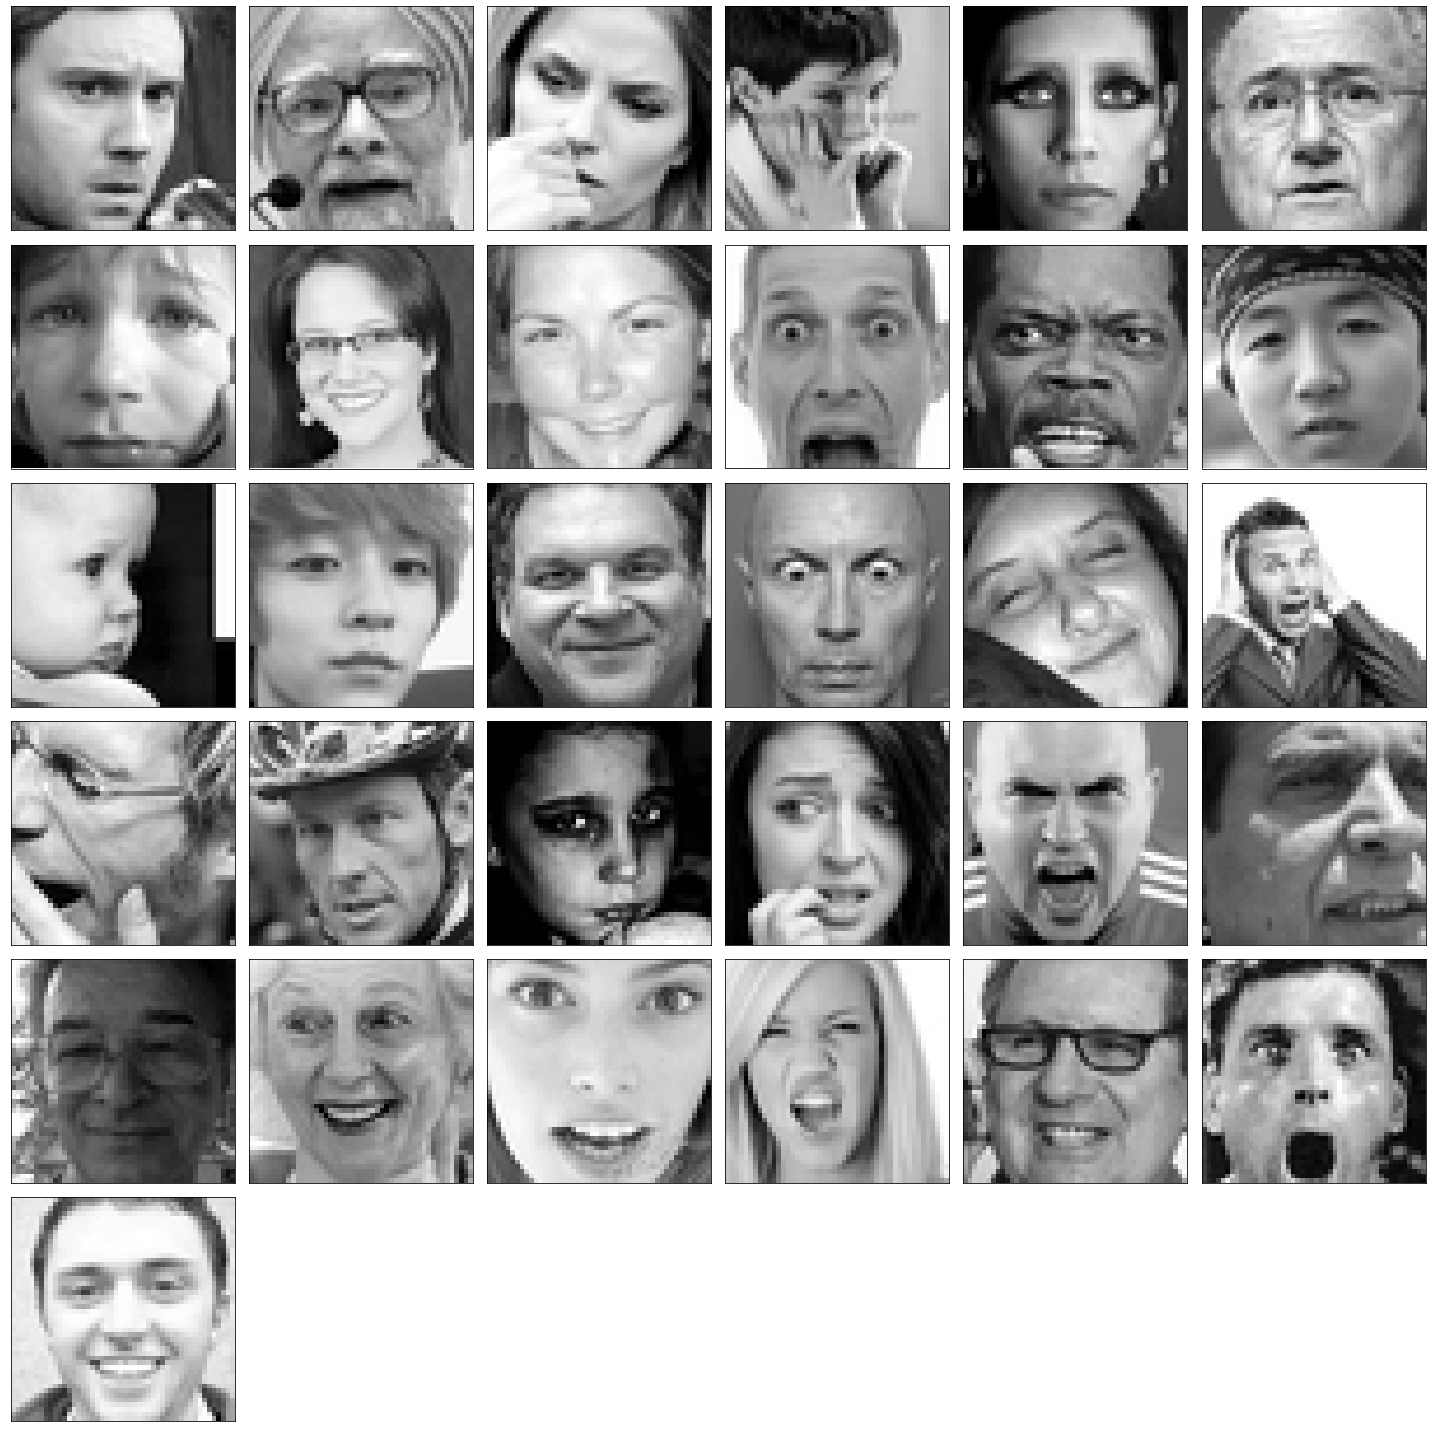

In [17]:
def overview(start, end, X):

    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i,:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,30, X_train)

## Model Architecture

In [18]:
model = Sequential()

# 1- conv
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

# 2- conv layer
model.add(Conv2D(256,(5,5),padding='same'))
model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))


# 3- conv Layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

 #4- conv layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

 #4- conv layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

# Flatting layer
model.add(Flatten())

#Fully connected layer 1
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Fully connected layer 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(7,activation= 'softmax'))

initial_learning_rate = 0.005


opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       4

## Data Agumentation

In [19]:
img_size = 48
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator= datagen_train.fit(X_train)
                                    
                                                   
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_validation.fit(X_val)
                                                    
                                                   

## Class weights to handle class imbalance problem

In [20]:
class_weights ={0:1,1:4,2:1.2,3:0.6,4:0.8,5:1.2,6:1}

In [21]:
class_weights

{0: 1, 1: 4, 2: 1.2, 3: 0.6, 4: 0.8, 5: 1.2, 6: 1}

## Training Model

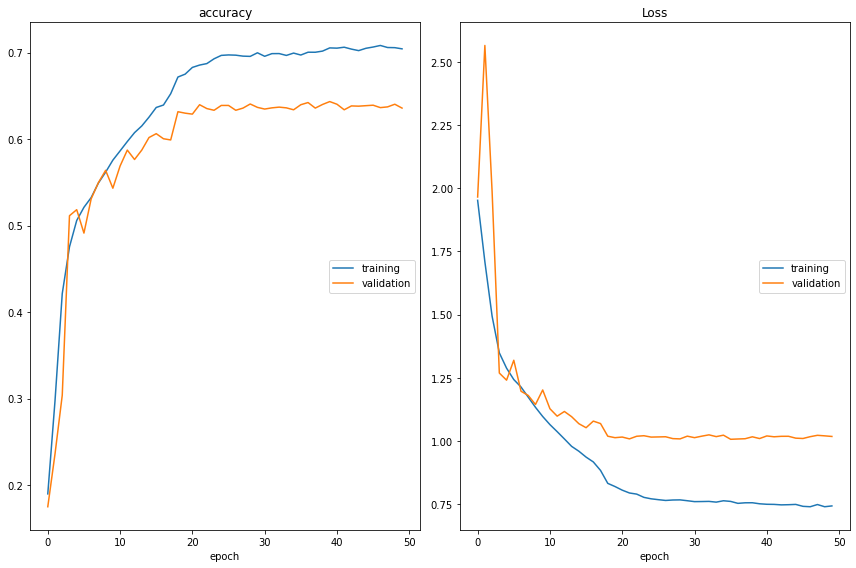

accuracy
	training         	 (min:    0.190, max:    0.708, cur:    0.704)
	validation       	 (min:    0.175, max:    0.643, cur:    0.636)
Loss
	training         	 (min:    0.739, max:    1.952, cur:    0.742)
	validation       	 (min:    1.006, max:    2.566, cur:    1.017)

Epoch 00050: saving model to drive/MyDrive/Data/Facial recognition/model_final_weights.h5


In [22]:
 epochs = 50
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_val)//batch_size

# Callback to save best weights
checkpoint = ModelCheckpoint("drive/MyDrive/Data/Facial recognition/model_final_weights.h5",monitor='val_accuracy',
                            save_weights_only = True,mode='max',verbose=1) # Only saving weights

reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2,
                             min_lr=0.00001,mode='auto')# Reduce learning rate is validation loss doesn't reduce

callbacks = [PlotLossesKeras(),checkpoint,reduce_lr]


history = model.fit(
     datagen_train.flow(X_train1,y_train, batch_size=batch_size),        
          validation_data=datagen_validation.flow(X_val, y_val,batch_size=batch_size),
    epochs=epochs,
   steps_per_epoch=steps_per_epoch,
    validation_steps= validation_steps,
    class_weight=class_weights,
    verbose=1,
    callbacks=callbacks)

## Saving model 

In [23]:
model_json = model.to_json()
with open("drive/MyDrive/Data/Facial recognition/model_final.json","w") as json_file:
    json_file.write(model_json)

## Loading model back

In [24]:
from keras.models import model_from_json
json_file = open('drive/MyDrive/Data/Facial recognition/model_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('drive/MyDrive/Data/Facial recognition/model_final_weights.h5')

In [25]:
model.compile(optimizer=Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['accuracy'])

## Accuracy 

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print ("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

model accuracy: 65.14%


In [27]:
score = model.evaluate(X_train, y_train, verbose=0)
print ("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

model accuracy: 77.45%


## Lets have look into confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix
y_prob1 = model.predict(X_train )
y_pred1 = [np.argmax(prob) for prob in y_prob1]
y_true1 = [np.argmax(true) for true in y_train]
confusion = confusion_matrix(y_pred1, y_true1)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[2757    2  224   77  309   26  137]
 [  42  434    2    0   18    8    2]
 [ 306    0 2714   90  519  132   97]
 [  63    0   46 6331   81   71  187]
 [ 296    0  511  156 2964    7  379]
 [  45    0  288  176   24 2888   16]
 [ 486    0  312  385  915   39 4147]]


In [29]:

y_prob = model.predict(X_test )
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]


In [30]:
confusion = confusion_matrix(y_pred, y_true)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[255   7  48  21  48   4  26]
 [ 17  41   7   2   6   4   3]
 [ 55   5 247  22  87  40  30]
 [ 16   1  13 718  24  16  33]
 [ 59   1  85  39 297   7  82]
 [ 17   0  63  22   7 337   9]
 [ 72   0  65  55 125   8 443]]


## Lets plot Histogram for predicted and true label

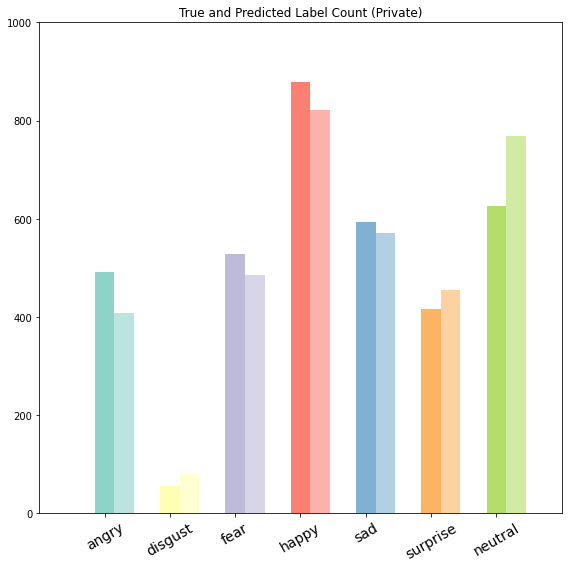

In [31]:
def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    ind = np.arange(1,8,1)  # the x locations for the groups
    width = 0.3  
    fig, ax = plt.subplots(figsize=(8,8))
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.6)
    ax.set_xticks(np.arange(1,8,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([0, 8])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution2(y_true, y_pred)

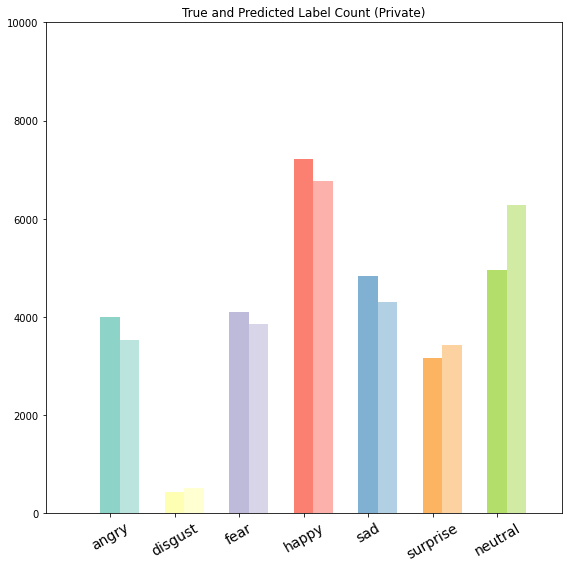

In [32]:
def plot_distribution1(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    ind = np.arange(1,8,1)  # the x locations for the groups
    width = 0.3  
    fig, ax = plt.subplots(figsize=(8,8))
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.6)
    ax.set_xticks(np.arange(1,8,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([0, 8])
    ax.set_ylim([0, 10000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution1(y_true1, y_pred1)


## End